In [1]:
import os

In [19]:
PATH = "C:\\Users\\osman\\Desktop\\AudioWAV"  # Ses dosyalarının olduğu klasör
print("Dosyalar başarıyla çıkarıldı!")


Dosyalar başarıyla çıkarıldı!


In [20]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [21]:
# Dosyaları listele, sadece .wav uzantılı olanları al
directory_list = [file for file in os.listdir(PATH) if file.endswith('.wav')]

file_emotion = []
file_path = []

for file in directory_list:
    # Dosya yolunu doğru birleştir
    file_path.append(os.path.join(PATH, file))
    part = file.split('_')
    if len(part) > 2:
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
    else:
        file_emotion.append('Unknown')

# DataFrame oluşturma
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)

# CSV olarak kaydetme
crema_df.to_csv("crema_df.csv", index=False)
print(crema_df.head())


  Emotions                                               Path
0    angry  C:\Users\osman\Desktop\AudioWAV\1001_DFA_ANG_X...
1  disgust  C:\Users\osman\Desktop\AudioWAV\1001_DFA_DIS_X...
2     fear  C:\Users\osman\Desktop\AudioWAV\1001_DFA_FEA_X...
3    happy  C:\Users\osman\Desktop\AudioWAV\1001_DFA_HAP_X...
4  neutral  C:\Users\osman\Desktop\AudioWAV\1001_DFA_NEU_X...


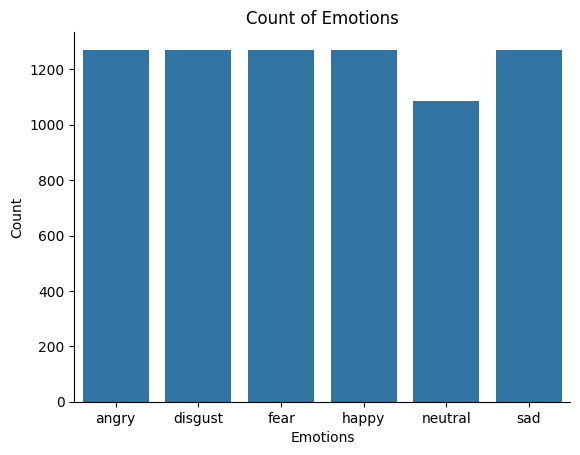

In [22]:
plt.title('Count of Emotions')
sns.countplot(x = crema_df.Emotions)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [23]:
def waveplot(data, sr, e):
  plt.figure(figsize = (10, 3))
  plt.title(f"{e} audio waveplot")
  librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, e):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize = (12, 3))
  plt.title(f"{e} audio spectrogram")
  librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')

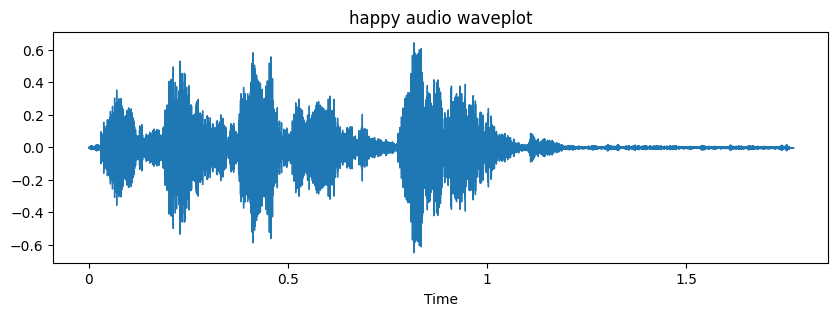

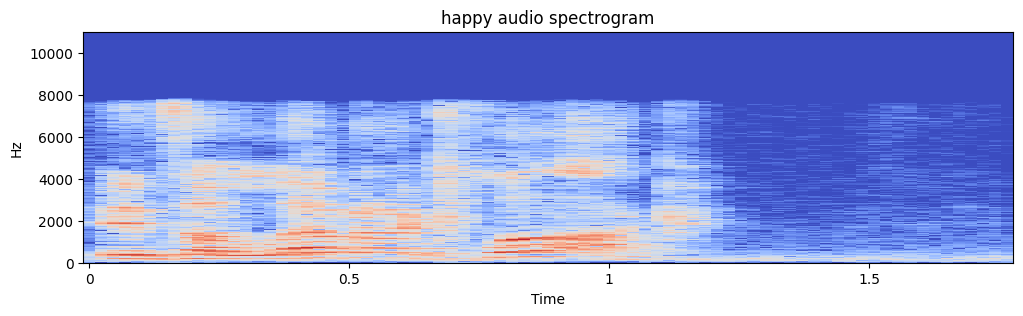

In [24]:
emotion = 'happy'
path = np.array(crema_df.Path[crema_df.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

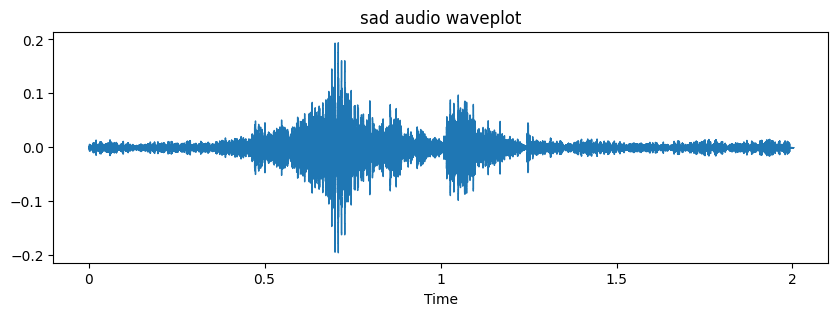

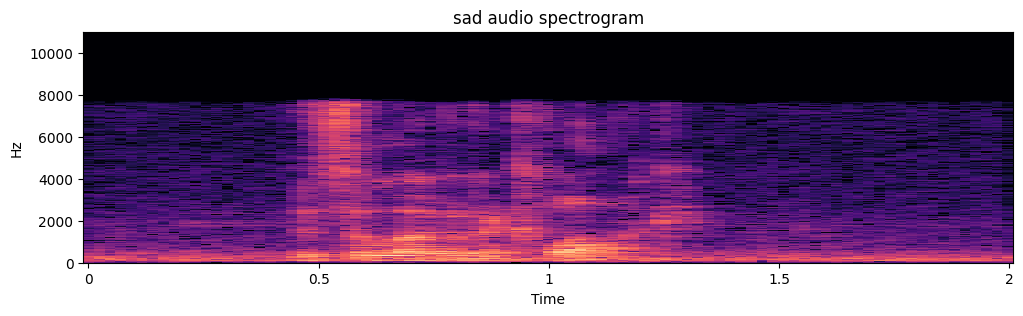

In [25]:
emotion = 'sad'
path = np.array(crema_df.Path[crema_df.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

In [26]:
def noise(data):
  noise_amp = 0.035 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
  shift_range = int(np.random.uniform(low = -5, high = 5) * 1000)
  return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

path = np.array(crema_df.Path)[1]
data, sample_rate = librosa.load(path)

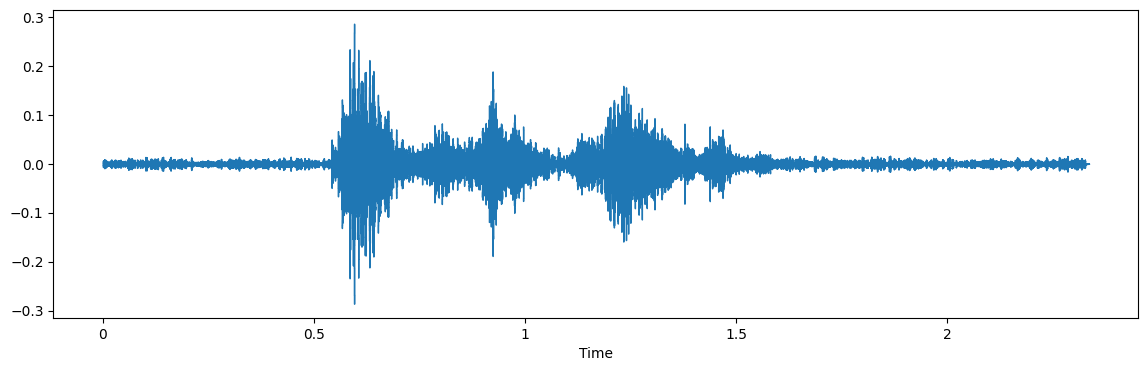

In [27]:
# Simple audio
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = data, sr = sample_rate)
Audio(path)

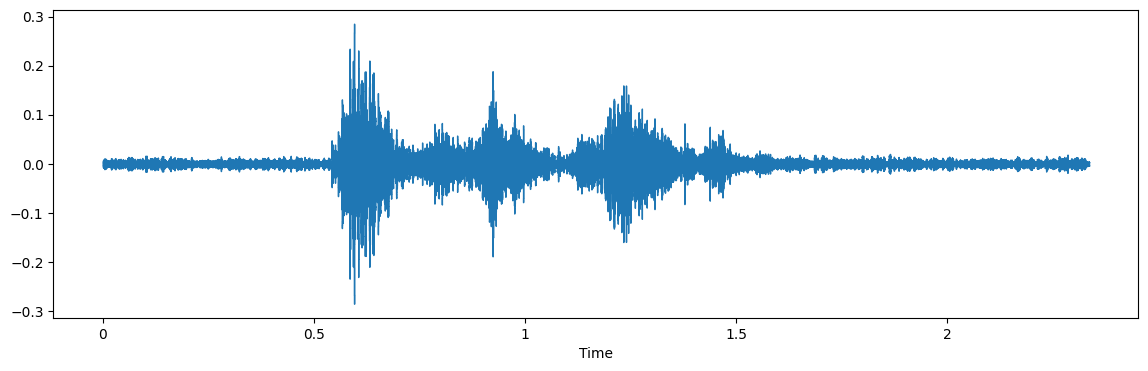

In [28]:
# Noise
x = noise(data)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

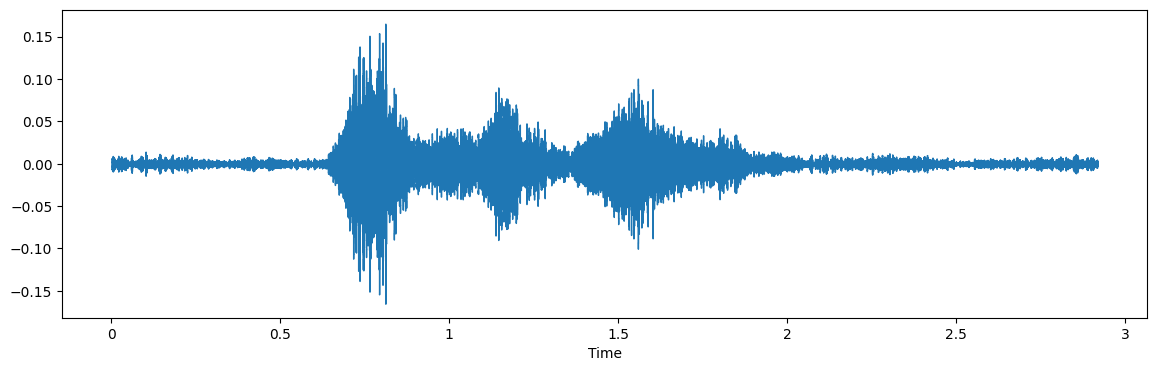

In [29]:
# Stretch
x = stretch(data)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

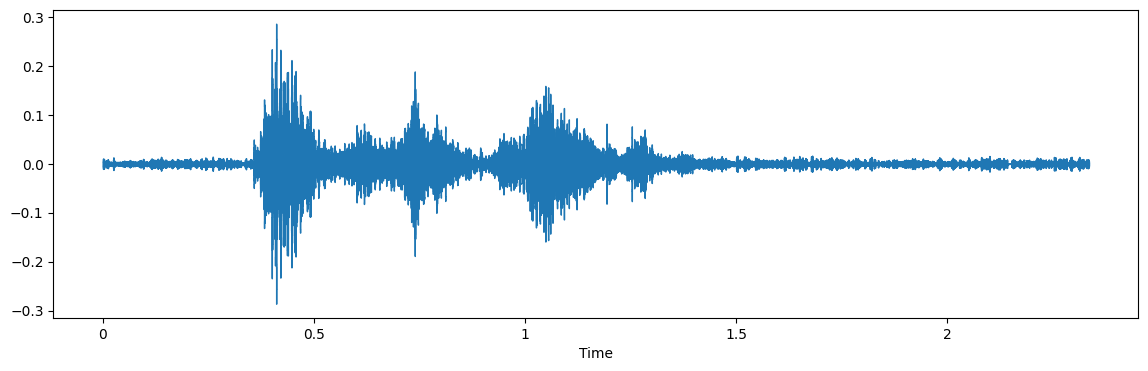

In [30]:
# Shift
x = shift(data)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

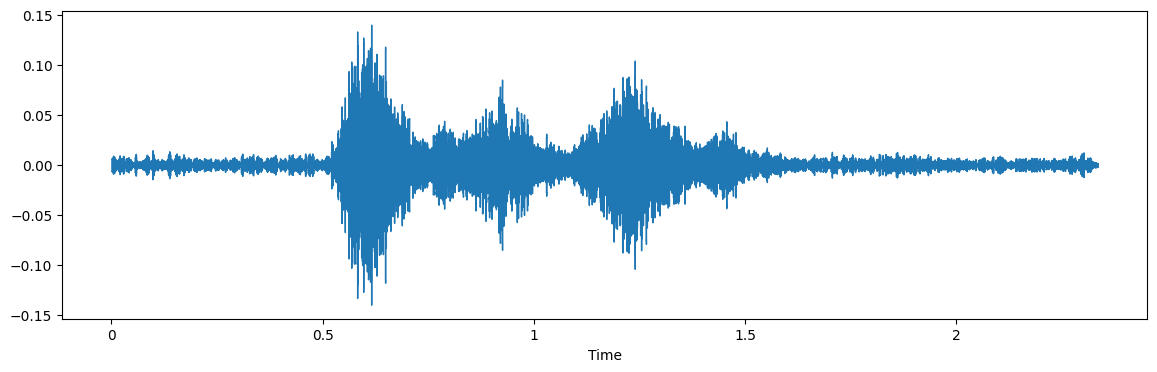

In [31]:
# Pitch
x = pitch(data, sampling_rate = sample_rate)
plt.figure(figsize = (14, 4))
librosa.display.waveshow(y = x, sr = sample_rate)
Audio(x, rate = sample_rate)

In [32]:
def extract_features(data):
    result = np.array([])

    mfcc = np.mean(librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 20).T, axis = 0)
    result = np.hstack((result, mfcc))

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.6)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    lowspeed_data = stretch(data, rate = 0.7)
    res3 = extract_features(lowspeed_data)
    result = np.vstack((result, res3))

    highspeed_data = stretch(data, rate = 1.25)
    res4 = extract_features(highspeed_data)
    result = np.vstack((result, res4))

    pitch_data = pitch(data, sample_rate, n_steps = 0.8)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    shift_data = shift(data)
    res6 = extract_features(shift_data)
    result = np.vstack((result, res6))

    return result

In [33]:
X, Y = [], []
for path, emotion in zip(crema_df.Path, crema_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [34]:
from concurrent.futures import ThreadPoolExecutor

def process_audio_file(path, emotion, X, Y):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    return (path, emotion)

if __name__ == "__main__":
    X, Y = [], []
    with ThreadPoolExecutor() as executor:
        futures = []
        for path, emotion in zip(crema_df.Path, crema_df.Emotions):
            future = executor.submit(process_audio_file, path, emotion, X, Y)
            futures.append(future)

        for future in futures:
            path, emotion = future.result()
#             print(path, " : ", emotion)

In [35]:
len(X), len(Y), crema_df.Path.shape

(44652, 44652, (7442,))

In [36]:
features = pd.DataFrame(X)
features['labels'] = Y
features.to_csv('features.csv', index = False)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-407.484192,140.990540,-10.000900,45.754429,-13.133901,24.014265,-13.238852,8.771015,-10.330442,-2.186386,...,3.209770,2.642173,-14.088666,5.907143,-17.209801,-3.695677,-11.661292,-2.713378,-8.539945,fear
1,-263.770421,39.309747,16.274911,11.736157,6.221037,4.700385,4.972286,0.568175,-2.456751,-2.584650,...,1.929305,-0.850055,-4.931120,-2.890166,-7.517364,-8.789692,-7.035623,-4.789816,-4.943536,fear
2,-442.272125,138.191071,-9.089021,44.752644,-13.147167,24.106014,-12.198725,9.914855,-9.762195,-3.324599,...,3.362695,2.089617,-14.796374,5.034459,-16.633648,-2.811949,-10.851615,-2.261070,-8.246381,fear
3,-439.205627,142.211456,-13.786719,46.345459,-15.608273,23.847990,-14.268194,9.626862,-10.093205,-1.463649,...,4.251439,3.591457,-13.694450,7.053976,-18.373907,-4.364599,-10.658477,-2.589056,-8.943233,fear
4,-433.935455,135.753983,-8.984969,44.461922,-14.885541,23.873482,-14.778403,13.239613,-13.315432,0.665206,...,6.794669,-7.048312,-10.568946,-1.651711,-18.910442,-1.936758,-13.677382,0.200324,-12.176516,fear


In [37]:
X = features.iloc[: ,: -1].values
Y = features['labels'].values

In [38]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42, shuffle = True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20), (33489, 6), (11163, 20), (11163, 6))

In [40]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20), (33489, 6), (11163, 20), (11163, 6))

In [41]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 20, 1), (33489, 6), (11163, 20, 1), (11163, 6))

In [42]:
model = Sequential([
    Conv1D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu',input_shape = (x_train.shape[1], 1)),
    Conv1D(64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(pool_size = 2, strides = 2, padding = 'same'),

    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Conv1D(128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    Dropout(0.25),
    MaxPooling1D(pool_size = 2, strides = 2, padding = 'same'),

    Conv1D(256, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),

    Flatten(),
    Dense(units = 6, activation = 'softmax'),

])

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 20, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 20, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 10, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 10, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 5, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,118 (945.77 KB)

 Trainable params: 242,118 (945.77 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
mdcp = ModelCheckpoint('best_model_weights.keras', monitor='val_accuracy', save_best_only=True)
# early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp, mdcp])

Epoch 1/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3525 - loss: 1.5364 - val_accuracy: 0.4229 - val_loss: 1.4012 - learning_rate: 0.0010
Epoch 2/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4283 - loss: 1.3966 - val_accuracy: 0.4495 - val_loss: 1.3633 - learning_rate: 0.0010
Epoch 3/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4672 - loss: 1.3336 - val_accuracy: 0.4830 - val_loss: 1.2946 - learning_rate: 0.0010
Epoch 4/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4844 - loss: 1.2832 - val_accuracy: 0.5057 - val_loss: 1.2469 - learning_rate: 0.0010
Epoch 5/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5126 - loss: 1.2236 - val_accuracy: 0.5230 - val_loss: 1.2061 - learning_rate: 0.0010
Epoch 6/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5358 - loss: 1.1693 - val_accuracy: 0.5507 - val_loss: 1.1403 - learning_rate: 0.0010
Epoch 7/100
524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5713 - loss: 1.

In [58]:
print("Testing Accuracy: " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

ValueError: Invalid dtype: object

In [45]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [46]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,disgust,disgust
1,fear,fear
2,angry,angry
3,fear,fear
4,fear,fear
5,disgust,disgust
6,disgust,disgust
7,fear,fear
8,disgust,disgust
9,sad,sad


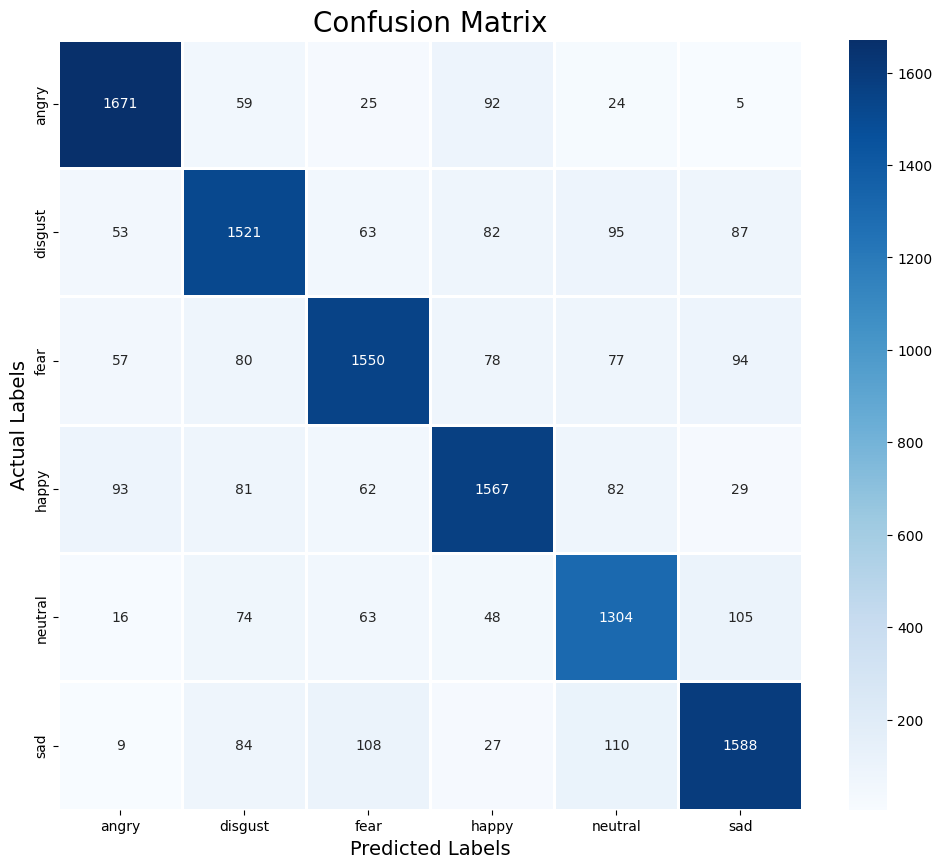

In [56]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
# PNG olarak kaydetme
plt.savefig('confusion_matrix.png')
plt.show()

In [54]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

print(classification_report(y_test, y_pred))
# PNG olarak kaydetme

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

       angry       0.88      0.89      0.89      1876
     disgust       0.80      0.80      0.80      1901
        fear       0.83      0.80      0.81      1936
       happy       0.83      0.82      0.82      1914
     neutral       0.77      0.81      0.79      1610
         sad       0.83      0.82      0.83      1926

    accuracy                           0.82     11163
   macro avg       0.82      0.82      0.82     11163
weighted avg       0.82      0.82      0.82     11163



<Figure size 640x480 with 0 Axes>

In [50]:
# Save the trained model
model.save('emotion_model.h5')

In [53]:
import joblib
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']